In [1]:
#-------------------------------------------------------------------------------
# generating and writing dummy input of pipline connection
'''
* ╣   ╔ ═ A     . 2
  ╠ ═ ╝         . 1
  C   ╚ ═ B     . 0
^^^^^^^^^^^^^^^^^
0 1 2 3 4 5 .....
'''
#-------------------------------------------------------------------------------
test_input = """* 0 2
C 1 0
╠ 1 1
╣ 1 2
═ 2 1
╝ 3 1
╔ 3 2
═ 4 0
A 5 2
╚ 3 0
═ 4 2
B 5 0"""
#-------------------------------------------------------------------------------

In [2]:
#-------------------------------------------------------------------------------
# writing to text file; future user supposted to provide this file
with open('piping_input.txt', 'w') as file:
    file.write(test_input)
#-------------------------------------------------------------------------------

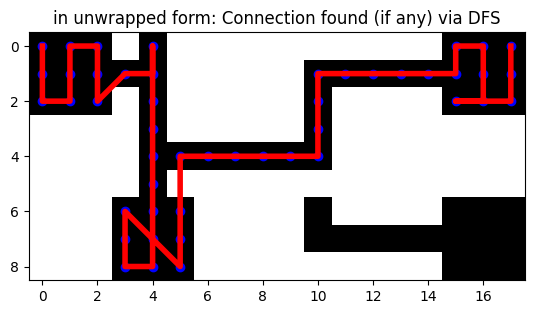

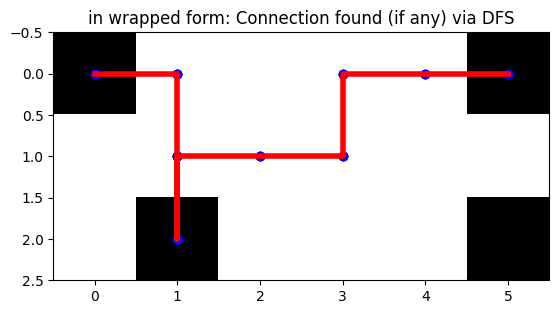

'CA'

In [3]:
#-------------------------------------------------------------------------------
# loading modules
import numpy as np
import matplotlib.pyplot as plt
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
def parse_file(file_path): # to read the input txt file of pipline network
    with open(file_path, 'r') as file:
        file_content = file.readlines()
    return file_content # now we have the input file content
#-------------------------------------------------------------------------------
#
file_content = parse_file('piping_input.txt')
# bottom-left must be the corner as per example given
#-------------------------------------------------------------------------------
grid_original = [] # allocation
grid_new = [] # allocation
#-------------------------------------------------------------------------------
source = [] # to hold source node location
sinks = []  # to hold sinks node location
#-------------------------------------------------------------------------------
# recording how vast the space is
max_x = 0
max_y = 0
#
for line in file_content: # checking every node to figure it type
  obj, pos_x, pos_y = line.strip().split() # collect data from each line
  pos_x, pos_y = int(pos_x), int(pos_y) # converting to intger
  grid_original.append([obj, pos_x, pos_y]) # storing in a list
  max_x = max(max_x, pos_x) # updatign max x
  max_y = max(max_y, pos_y) # updatign max y
  #
  if obj == '*': # is this the source?
    # BTW source must be connected, so if not then break -  added later
    obj = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])  # open to all sides
    source = [pos_x, pos_y] # keeping source node for quick check
  elif obj.isalpha() and obj.isupper(): # checking for sink, as named alphatically
    sinks.append([obj, pos_x, pos_y]) # for later reporting use
    obj = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])  # open to all sides
  # pipline symbols - LRUP
  # lable for internal use - better to frame input this way rather than symbols
  elif obj == '═':
    obj = np.array([[0, 0, 0], [1, 1, 1], [0, 0, 0]])
  elif obj == '║':
    obj = np.array([[0, 1, 0], [0, 1, 0], [0, 1, 0]])
  elif obj == '╔':
      obj = np.array([[0, 0, 0], [0, 1, 1], [0, 1, 0]])
  elif obj == '╗':
      obj = np.array([[0, 0, 0], [1, 1, 0], [0, 1, 0]])
  elif obj == '╚':
      obj = np.array([[0, 1, 0], [0, 1, 1], [0, 0, 0]])
  elif obj == '╝':
      obj = np.array([[0, 1, 0], [1, 1, 0], [0, 0, 0]])
  elif obj == '╠':
      obj = np.array([[0, 1, 0], [0, 1, 1], [0, 1, 0]])
  elif obj == '╣':
      obj = np.array([[0, 1, 0], [1, 1, 0], [0, 1, 0]])
  elif obj == '╦':
      obj = np.array([[0, 0, 0], [1, 1, 1], [0, 1, 0]])
  elif obj == '╩':
      obj = np.array([[0, 1, 0], [1, 1, 1], [0, 0, 0]])
  grid_new.append([obj, pos_x, pos_y]) # storing as new format - internal use
#-------------------------------------------------------------------------------
rows = max_y + 1
cols = max_x + 1
#-------------------------------------------------------------------------------
def get_obj_from_posXY(data_to_search_in, for_pos_x, for_pos_y): # for search
    for item in data_to_search_in:
        obj, pos_x, pos_y = item
        if pos_x == for_pos_x and pos_y == for_pos_y:
            return obj
#-------------------------------------------------------------------------------
network = [[np.eye(3,3).astype(int)*0 for _ in range(cols)] for _ in range(rows)] # placeholder
#-------------------------------------------------------------------------------
for obj, pos_x, pos_y in grid_new:
  obj = get_obj_from_posXY(grid_new, pos_x, pos_y)
  row_ind = rows - pos_y - 1
  col_ind = pos_x
  network[row_ind][col_ind] = obj
#-------------------------------------------------------------------------------
network_blk = np.block(network) # now we can do a path search for 1 values
#-------------------------------------------------------------------------------
visited = np.zeros(network_blk.shape, dtype=bool) # palceholder
#-------------------------------------------------------------------------------
def is_on_continous_line(x, y, matrix, visited):
    rows, cols = matrix.shape
    return 0 <= x < rows and 0 <= y < cols and not visited[x, y] and matrix[x, y] == 1
#-------------------------------------------------------------------------------
def path_search_via_dfs(matrix, visited, x, y): # Depth-First Search (DFS)
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)] # sides
    stack = [(x, y)]
    path = []
    #
    while stack:
        cx, cy = stack.pop()
        if not visited[cx, cy]:
            visited[cx, cy] = True
            path.append((cx, cy))
            for dx, dy in directions:
                nx, ny = cx + dx, cy + dy
                if is_on_continous_line(nx, ny, matrix, visited):
                    stack.append((nx, ny))
    return path
#-------------------------------------------------------------------------------
path = path_search_via_dfs(network_blk, visited, 0, 0) # executing
#-------------------------------------------------------------------------------
plt.imshow(network_blk, cmap='gray_r') # pipeline to overlay path on
#
path_x, path_y = zip(*path)
#
plt.plot(path_y, path_x, color='red', linewidth=4) # path
plt.scatter(path_y, path_x, color='blue') # endcoded connections
#
plt.title("in unwrapped form: Connection found (if any) via DFS")
plt.show()
#-------------------------------------------------------------------------------
def get_original_nodes_on_network(matrix, block_size=3): # since we did a tarnsformation
    rows, cols = matrix.shape
    reduced_rows = rows // block_size
    reduced_cols = cols // block_size
    reduced_matrix = np.zeros((reduced_rows, reduced_cols), dtype=int)
    #
    for i in range(reduced_rows):
        for j in range(reduced_cols):
            block = matrix[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            reduced_matrix[i, j] = 1 if np.sum(block) > (block_size**2) / 2 else 0
    return reduced_matrix
#-------------------------------------------------------------------------------
def get_path_on_original_network(path, block_size=3): # to get repsective path
    return [(x // block_size, y // block_size) for x, y in path]
#-------------------------------------------------------------------------------
network_original = get_original_nodes_on_network(network_blk, block_size=3)
path_on_original = get_path_on_original_network(path, block_size=3)
#-------------------------------------------------------------------------------
plt.imshow(network_original, cmap='gray_r')
path_x, path_y = zip(*path_on_original)
#
plt.plot(path_y, path_x, color='red', linewidth=4)
plt.scatter(path_y, path_x, color='blue')
#
plt.title("in wrapped form: Connection found (if any) via DFS")
plt.show()
#-------------------------------------------------------------------------------
sinks_on_path = []
for pos_x, pos_y in path_on_original:
  sinks_on_path.append(get_obj_from_posXY(sinks, pos_y, max_y - pos_x))
no_None = [item for item in sinks_on_path if item is not None]
no_repeat = list(set(no_None))
output_string = "".join(no_repeat)
output_string
#-------------------------------------------------------------------------------